# Skill assessment - explanation
***

**Author**: Chus Casado Rodríguez<br>
**Date**: 03-03-2023<br>


**Introduction**:<br>

In this notebook I'll test and explain the procedure to assess the EFAS skill in predicting flood events eventwisely. By eventwisely I mean that I will look at the duration of the whole event, to check if at any point in time during the event there was a notification regarding that event.

For the sake of understanding, I will limit the analysis to one station, one meteorological forecast, and a short period of time that includes a flood event. I will be looking at station ID 350 (in the Rhine river) during the month of July 2021, where a major flood event hit this catchment. I will only use the discharge forecasted with the ECMWF ensemble forcing.

The notification criteria that I will apply are:

* Leadtime larger than 48 h.
* Total probability threshold of 30%. To compute total probability I will use the model mean.
* For a timestep to be considered an event, the probability threshold must be exceeded for at least 3 consecutive forecasts.


In [2]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

path_root = os.getcwd()

import warnings
warnings.filterwarnings("ignore")

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

os.chdir('../py/')
from computations import *
from plots import *
os.chdir(path_root)

## 1 Data

In [3]:
# stations and study period
stn = 1358, #350 #934
start, end = datetime(2021, 7, 1), datetime(2021, 7, 31)
forcing = 'EUE'

In [4]:
name = 'explanation'

# path where results will be saved
results_path = '../results/'
path_out = f'{results_path}skill/{name}/eventwise/'
if os.path.exists(path_out) is False:
    os.makedirs(path_out)

In [5]:
# coordinate reference system when plotting maps
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000, globe=ccrs.Globe(ellipse='GRS80'))

### 1.1 Stations

I load all the stations in the catchment and select the single station in which I am interested for this test-case.

In [6]:
# load selected points for all the catchments
stations = pd.DataFrame()
catchments = []
folders = ['Rhine'] #os.listdir(f'{results_path}reporting_points/')
for folder in folders:
    try:
        stn_cat = pd.read_csv(f'{results_path}reporting_points/{folder}/points_selected.csv', index_col='station_id')
        stations = pd.concat((stations, stn_cat))
        catchments.append(folder)
    except:
        continue
stations = pd.DataFrame(stations.loc[stn]).transpose()
print('no. stations:\t\t\t{0}'.format(stations.shape[0]))

KeyError: 1358

### 1.2 Forecast: exceedance

I load the preprocessed forecast data. In a previous [notebook](4_0_forecast_exceedance_review.ipynb), the forecasted discharge was converted to probability of exceeding the 5-year return period threshold. The ouput of that process is a NetCDF file per station with the forecasted probability of exceedance. 

In [ ]:
# models
models = {'COS': {'members': 20, 'leadtimes': 22},
          'DWD': {'members': 1, 'leadtimes': 28},
          'EUD': {'members': 1, 'leadtimes': 40},
          'EUE': {'members': 51, 'leadtimes': 40},}
min_leadtime = min([models[m]['leadtimes'] for m in models])

In [ ]:
# load probability of exceeding the discharge threshold in the FORECAST data
path_forecast = '../data/exceedance/forecast/'
fore_exc = {}
for stn in stations.index:
    da = xr.open_dataarray(f'{path_forecast}{stn:04d}.nc')
    if 'id' in da.coords:
        da = da.drop_vars('id')
    fore_exc[stn] = da
    da.close()

# convert into a Dataset
stn = stations.index[0]
fore_exc = xr.Dataset(fore_exc, coords={'model': fore_exc[stn].model,
                                        'forecast': fore_exc[stn].forecast,
                                        'leadtime': fore_exc[stn].leadtime})

In [ ]:
# trim data to the study period
print(f'Study period\nstart:\t{start}\nend:\t{end}')
fore_exc = fore_exc.sel(forecast=slice(start - timedelta(days=10), end))

### 1.3 Reanalysis: exceedance & events

I load the preprocessed reanalysis data. In a previous [notebook](2_2_reanalysis_preprocessing.ipynb), the reanalysis discharge data was preprocessed to create timeseries of exceedance over the 5-year return period threshold.

Out of the exceedance timeseries I calculate another timeseries of the onset of flood events.

In [ ]:
path_reanalysis = '../data/exceedance/reanalysis/'

# load probability of exceeding the discharge threshold in the REANALYSIS data
rean_exc = pd.read_parquet(f'{path_reanalysis}/exceedance_rl5.parquet')
rean_exc.columns = rean_exc.columns.astype(int)
rean_exc = rean_exc.loc[start:end, stations.index.tolist()]

# compute onsets of the flood events
rean_onsets = rean_exc.astype(int).diff(axis=0) == 1
rean_onsets.iloc[0,:] = rean_exc.iloc[0,:]

# create a DataArray with the number of observed events per station
n_events_obs = xr.DataArray(rean_onsets.sum(), dims=['id'], coords={'id': rean_onsets.columns.tolist()})
print('no. events:\t\t\t{0}'.format(n_events_obs.sum().data))

# select stations with events
mask_stn = (n_events_obs > 0).to_pandas()
print('no. stations with events:\t{0}'.format(mask_stn.sum()))

## 2 Assess skill

In this section I will compute the skill of the EFAS predictions in terms of different metrics: recall, precision and the f1-score. The three metrics are based in the contingency table of hits ($TP$ for true positives), false alarms ($FP$ for false positives) and misses ($FN$ for false negatives).

$$recall = \frac{TP}{TP + FN}$$
$$precision = \frac{TP}{TP + FP}$$
$$f1 = \frac{2 \cdot TP}{2 \cdot TP + FN + FP}$$

### 2.1 Reformat data

#### 2.1.1 Observed probability of exceendace

In the case of the observations, I only need to convert the `pandas.DataFrame` into a `xarray.DataArray`.

In [7]:
# create a DataArray with observed threshold exceedance
obs = df2da(rean_exc, dims=['id', 'datetime'], plot=False, figsize=(16, 20), title='observed exceendace')
obs = obs.sel(id=stn).astype(int)

print(obs.dims)
print(obs.shape)

NameError: name 'rean_exc' is not defined

#### 2.1.2 Predicted probability of exceedance

To be able to apply the notification criteria in a simple manner, I need to reshape the exceedance forecast. Up until now, the exceedance forecast is saved in a matrix where the `forecast` is one dimension and the `leadtime` is another dimension (Figure 1). This format is very convinient in therms of storage, since it's very compact. However, this shape is not easy to compare against the observed exceedances of the discharge threshold because the dimensions don't match (`obs` has a single dimension `datetime` that doesn't exist in the exceedance forecast).

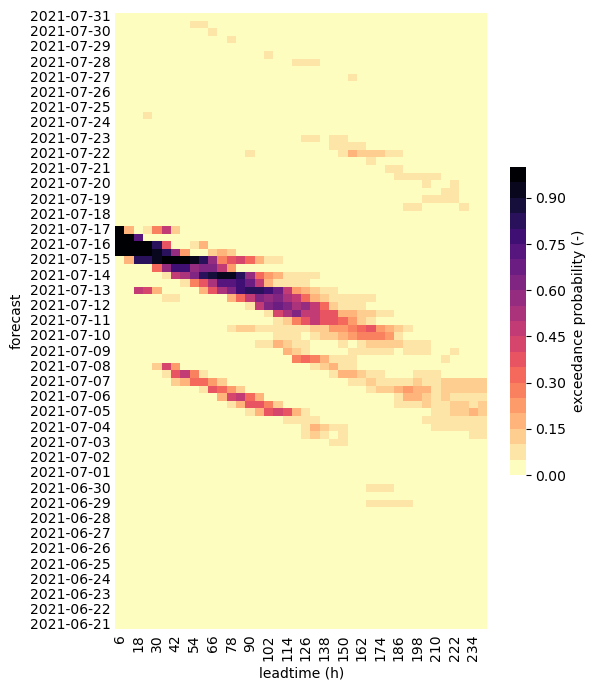

In [11]:
# create DataArray of predicted exceedance
pred = fore_exc.to_array(dim='id')
# extract and plot forecast data in the original format
pred = pred.sel(id=stn, model=forcing)#, forecast=slice(st, en))#'2021-06-25', '2021-07-28'))

# plot raw data
cmap = plt.cm.magma_r
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('probability', cmaplist, cmap.N)
bounds = np.arange(0, 1.01, .05)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
xticklabels = (pred.leadtime / np.timedelta64(1, 'h')).astype(int).data
plot_DataArray(pred.sel(forecast=slice(None, None, -1)),
               cmap=cmap, norm=norm, ytick_step=2, ylabel='forecast', xtick_step=2, xlabel='leadtime (h)', figsize=(6, 8),
               xticklabels=xticklabels, cbar_kws={'shrink': .5, 'label': 'exceedance probability (-)'})

>***Figure 1**. Original format of the forecast data. The matrix represents probability of exceeding the 5-year return period of discharge. It corresponds to a single station an meteorological forcing.*

The diagonal shapes in Figure 1 represent the same timestep. As we move backwards in terms of forecast time (moving down in the figure), the leadtime increases (moving right in the figure).

Instead, I will reshape the original exceendance forecast into a new matrix in which a dimension named `datetime` represents athe actual date and time, and another dimension represents `leadtime`. In this way, a column in the matrix represents the same timestep and can be easily compared against observations. The drawback of this approach is that it will create missing values in the lower-left and upper-right corners of the matrix, but this only applies to the beginning and end of the study period.

To make clear what this reshaping means, I will do it step by step. Figure 2 represents the first transformation. I took the matrix in Figure 1 and every new forecast is shifted 2 timesteps (12 hours) towards the right. The result is a matrix in which every column represents the same timestep. However, the new matrix has a huge amount of gaps.

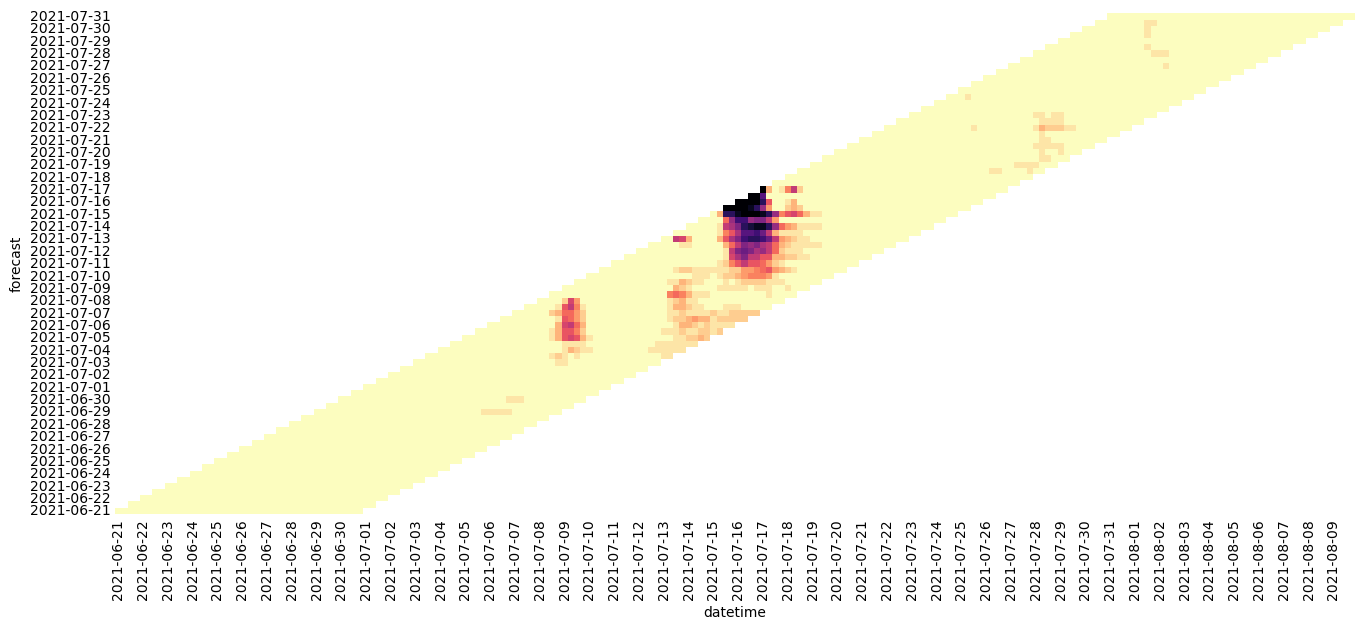

In [12]:
# reshape the forecast data and plot it
st, en = [pd.to_datetime((pred.forecast[i] + pred.leadtime[i]).data) for i in [0, -1]]
coords = {'datetime': pd.date_range(st, en, freq='6h'),
          'forecast': pred.forecast}
aux = xr.DataArray(coords=coords, dims=list(coords))
for j, forecast in enumerate(pred.forecast):
    io = j * 2
    ie = io + len(pred.leadtime)
    aux[io:ie, j] = pred.sel(forecast=forecast)

plot_DataArray(aux.transpose().sel(forecast=slice(None, None, -1)),
               cmap=cmap, norm=norm, ytick_step=2, ylabel='forecast', xtick_step=4, xlabel='datetime', figsize=(16, 6.5),
               cbar=False)

> ***Figure 2**. Result of the first step in the reshaping process. Every forecast has been shifted 2 timesteps (12 h) so that every column in the matrix represents the same timestep.*

Another feature of the matrix in Figure 2 is that, for every column, the cells on top represent the forecast closest to that timestep (6-12 h leadtime), whereas the cells at the bottom represent the furthest one (10 days leadtime). I will use this feature in the next step. I will "project" the matrix towards the top; it will cause that I lose the forecast date, which I will convert into leadtime. Since every forecast has 40 leadtimes with 6 h resolution, but the forecast frequency is 12 h, every timestep is predicted by 20 forecast. Therefore, the resulting matrix will have 20 leadtimes (not 40) with 12 h resolution (instead of 6 h). 

Figure 3 shows the result of this projection step. The new matrix has a lot less gaps and keeps the two main features of Figure 2: columns represent the same timestep; the top row corresponds to the closest forecast, whereas the bottom row to the furthest. Actually, the gaps we see in Figure 3 will only occur at the beginning and end of the study period, so when studying 2 years of data (as the case of the main analysis) these gaps are negligible.

In [13]:
pred_reshape = reshape_DataArray(pred, trim=False)
print(pred_reshape.dims)
print(pred_reshape.shape)

plot_DataArray(pred_reshape,
               cmap=cmap, norm=norm, xtick_step=4, ytick_step=2, xlabel='datetime', ylabel='leadtime (h)', figsize=(16, 2),
               cbar_kws={'shrink': .666, 'label': 'exceedance probability (-)'})

('leadtime', 'datetime')
(20, 200)


> ***Figure 3**. Matrix resulting from projecting the matrix in Figure 2 in the `forecast` dimension.*

The last little transformation is removing the periods at the beginning and at the end which contain gaps. The result is Figure 4, which will be the final result of the reshaping process.

('leadtime', 'datetime')
(20, 121)


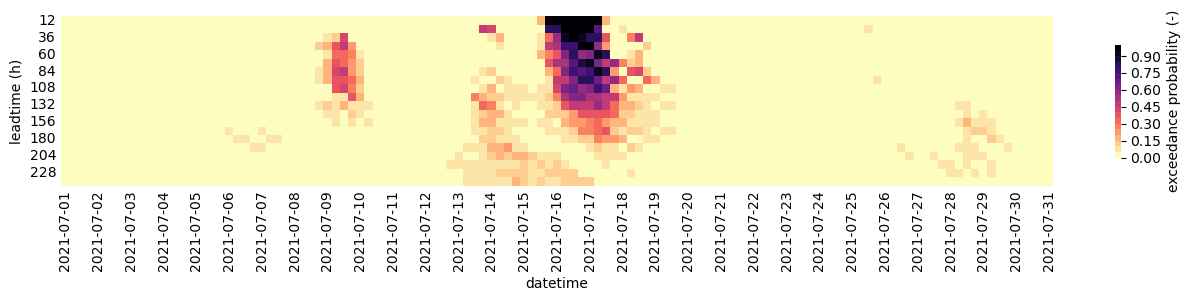

In [14]:
pred_reshape = reshape_DataArray(pred, trim=True)
pred_reshape = pred_reshape.loc[dict(datetime=obs.datetime)]
print(pred_reshape.dims)
print(pred_reshape.shape)

plot_DataArray(pred_reshape,
               cmap=cmap, norm=norm, xtick_step=4, ytick_step=2, xlabel='datetime', ylabel='leadtime (h)', figsize=(16, 2.2),
               cbar_kws={'shrink': .666, 'label': 'exceedance probability (-)'})

>***Figure 4**. Final matrix of the reshaping process. Columns represent timesteps and rows increasing leadtime.*

### 2.2 Skill

Once the forecasted dataset is formatted as above explained, we must define what an event is (probability threshold, persistence, minimum leadtime), and then it's "easy" to compute the forecasted events and calculate the performance (recall, precision and f1-score).

#### 2.2.1 Define criteria

In this test-case I will use the current notification criteria:

* Probability threshold: 30 %.
* Persistence of 3 consecutive forecast.
* Leadtime larger than 48 h, i.e., 60 h or more.

In [15]:
probability = .3
persistence = (3, 3) # (window width, number of positives in that window)
min_leadtime = None

#### 2.2.2 Compute events

The function `compute_events` applies the previous criteria on the forecasted exceedance probability matrix (Figure 4). It consists of three steps:

1. **Probability threshold**. By applying the probability threshold, the matrix is converted into a boolean matrix (exceeds or not exceeds). At this step the matrix keeps its dimensions.
```
exceedance = (forecast >= probability).astype(int)
```

2. **Persistence**. A rolling sum over `leadtime` of width equal to the persistence criterion computes the number of consecutive positive forecasts. When this sum is equal to the persitence value, the cell complies with the criterion. At this step, the matrix still keeps its original dimensions.
```
events = exceedance.rolling({'leadtime': persistence[0]}).sum() >= persistence[1]
```

3. **Leadtime**. For leadtimes larger than the minimum, we check the timesteps at which there is at least one positive value. The matrix is, hence, reduced to only one dimension: `datetime`.
```
events.sel(leadtime=slice(min_leadtime, None)).any('leadtime').astype(int)
```

***

In [22]:
# compute events
pred_events = compute_events(pred_reshape, probability, persistence, by_leadtime=True)#min_leadtime=min_leadtime)

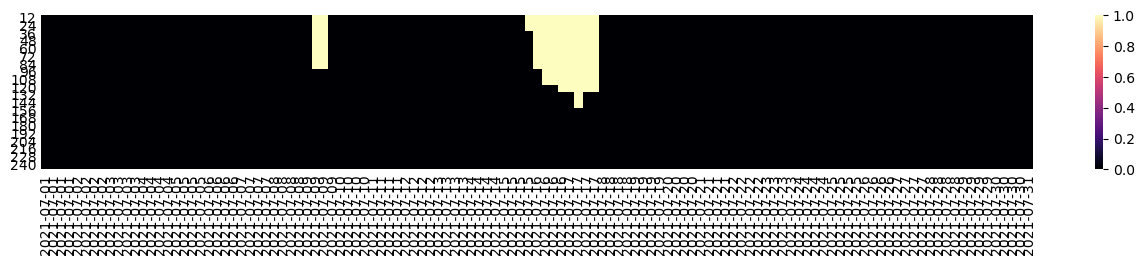

In [23]:
plot_DataArray(pred_events, )

In [24]:
# calculate the number of predicted events
n_events_pred = count_events(pred_events).compute()

In [27]:
# compute hits, misses and false alarms
if 'leadtime' in pred_events.dims:
    hits = [compute_hits(obs, pred_events.sel(leadtime=lt), center=True, w=5) for lt in pred_events.leadtime.data]
    hits = xr.concat(hits, dim='leadtime').compute()

In [31]:
n_events_pred

<xarray.DataArray (leadtime: 20)>
array([2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])
Coordinates:
  * leadtime  (leadtime) int32 12 24 36 48 60 72 84 ... 180 192 204 216 228 240
    id        int32 350

In [33]:
for var in ['TP', 'FN', 'FP']:
    plt.plot(hits.leadtime, hits[var])
plt.plot(n_events_pred.leadtime, n_events_pred.data, 'k')

In [26]:
events_ = events.copy()
for lt in events_.leadtime.data:
    events_.loc[dict(leadtime=lt)] = events.sel(leadtime=slice(lt, None)).any('leadtime').astype(int)

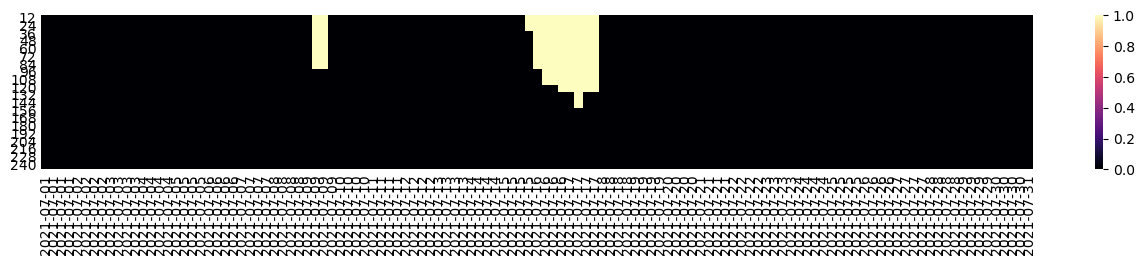

In [27]:
plot_DataArray(events_)

***

In [21]:
# compute events
pred_events = compute_events2D(pred_reshape, probability, persistence, min_leadtime=min_leadtime)

#### 2.2.3 Performance

The function `compute_hits` compares the matrixes of observed and predicted events and outputs a dataset that contains the true positives (TP), false negatives (FN) and false positives (FP). Before comparing the two matrixes, the function allows to create a buffer over the prediction. This buffer is meant to consider small lags in time between predicted and the observed events; the buffer can be symmetrical (`center=True`) or asymmetrical (`center=False`) and its width is defined with the attribute `w`.

* An observed event is considered a true positive if at least one timestep during the obserserved event was predicted by the buffered matrix. 
* False negatives are the difference between the number of observed events and the number of true positives.
* False positives are the difference between the number of predicted events and the number of true positives.

With these three values the performance metrics (recall, precision, f1) can be computed.

In [22]:
# compute hits, missses and false alarms
hits = compute_hits(obs, pred_events, center=True, w=5)

#### 2.2.4 Graphical explanation

Figure 5 shows graphically the whole process of computing the skill:

1. The timeseries of observed events (exceedances of the 5-year return period of discharge).
2. A forecast matrix that shows when the forecasted discharge exceeds the 5-year discharge with a probability larger than 30 %.
3. The timeseries of predicted events computed from the previous matrix by applying the persistence criterion.
4. A buffer on the timeseries of predicted events.
5. The timeseries of true positives, i.e., timesteps at which both the matrix in step 1. and that in step 4. are positive.

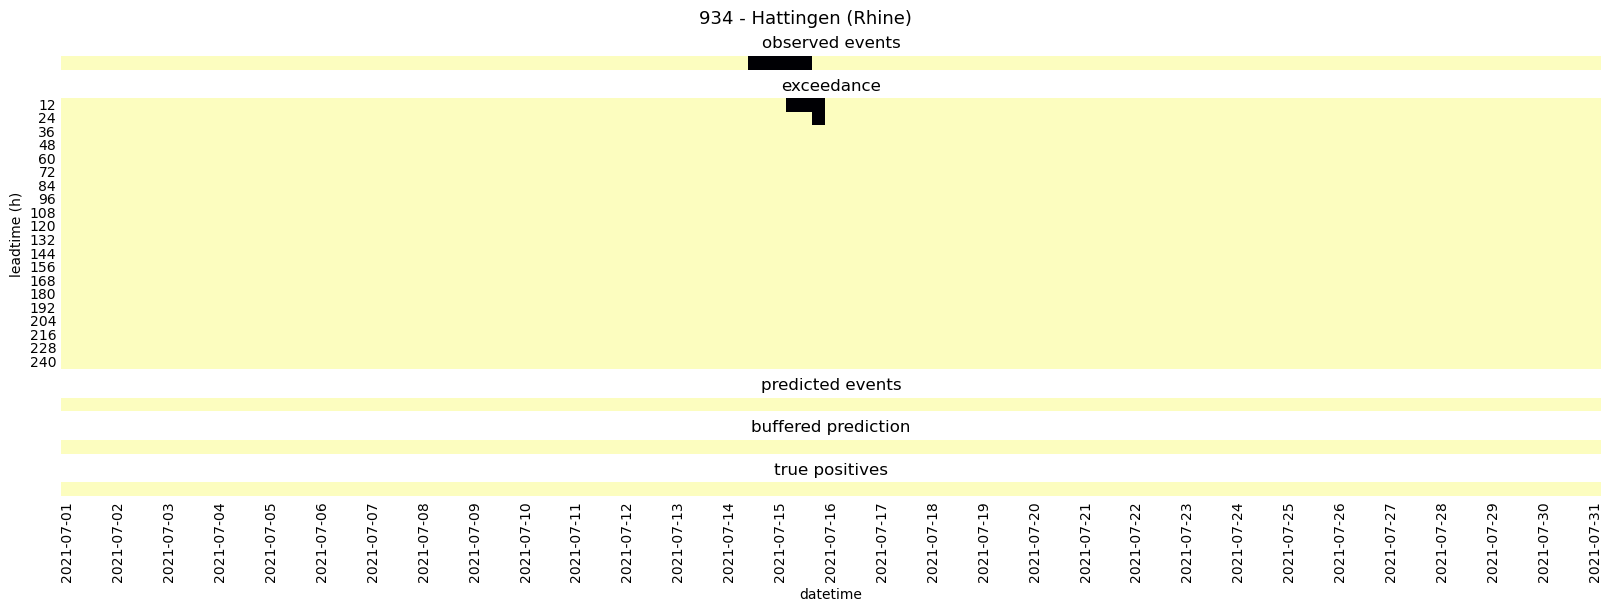

In [23]:
das = {'observed events': obs,
       'exceedance': compute_events2D.exceedance.sel(leadtime=slice(min_leadtime, None)),
       'predicted events': pred_events,
       'buffered prediction': compute_hits.buffer,
       'true positives': compute_hits.true_positives}

fig = plt.figure(figsize=(16, 6), constrained_layout=True)
height_ratios = [len(da.leadtime) if 'leadtime' in da.dims else 1 for key, da in das.items()]
gs = fig.add_gridspec(nrows=len(height_ratios), height_ratios=height_ratios)

for i, (label, da) in enumerate(das.items()):
    ax = fig.add_subplot(gs[i])
    if i + 1 < len(height_ratios):
        xticklabels, xlabel = [], None
    else:
        xticklabels, xlabel = da.datetime.data, 'datetime'
    if label == 'exceedance':
        ylabel = 'leadtime (h)'
    else:
        ylabel = None
    plot_DataArray(da, xtick_step=4, cbar=False, title=label, xticklabels=xticklabels, xlabel=xlabel,
                   ylabel=ylabel, ax=ax, cmap='magma_r')
    
fig.suptitle('{0} - {1} ({2})'.format(stn, *stations.loc[stn, ['name', 'catchment']]), fontsize=13);

> ***Figure 5**. Graphical explanation of the skill computation. The top plot shows the exceedances of the 5-year return period in the "observed" (water balance) discharge. The second plot shows the timesteps and leadtimes in which the forecast exceeds this 5-year return period with at least a 30 % probability. The third plot shows the timesteps in which the forecast complies with the persistence critera, i.e., at least 3 consecutive forecasts predict an event at that timestep. The fourth plot shows a buffer of 2 timesteps (12 h) over the previous predicted events, to allow for some lag between prediction and observation. The bottom plot shows the true positives, i.e., the timesteps at which both the observed and the buffered predicted events are positive.*

Out of the three observed events, the forecast correctly predicts (with these notification criteria) 2 events. Therefore, there is one false negative (miss) and no false positives (false alarm).

## 3 Idea

If we look at Figure 4 in 3 dimensions (Figure 6), the matrix can be seen as a 2D probability density function (PDF), where flood events are clusters of higher probability. A large amount of this information (both in terms of probability and duration of the event) is lost when applying the probability threshold criteria. As an example, compare Figure 4 with the second plot in Figure 5. The persistence criterion (and the buffer) seems to be proxies to replace this lost of information.

It would be interesting to try another procedure that would find clusters of higher probability (events) and computes a cumulative probability (CDF, cumulative density function) of that event. In this approach, notifications would be sent when the CDF of an events exceeds certain value.

In [20]:
xx, yy = np.meshgrid(np.arange(0, pred_reshape.shape[1]), np.arange(0, pred_reshape.shape[0]))

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, pred_reshape.data, cmap=cmap, norm=norm, rcount=80, ccount=480, edgecolor='none', alpha=.666)
ax.view_init(45, 70)
ax.set(xlabel='datetime', ylabel='leadtime (h)', zlabel='probability')
ax.set_xticks(np.arange(0, pred_reshape.shape[1], 16))
ax.set_xticklabels(pd.to_datetime(pred_reshape.datetime.data[::16]).date)
ax.set_yticks(np.arange(0, pred_reshape.shape[0], 4))
ax.set_yticklabels(pred_reshape.leadtime.data[::4])
ax.set_title('forecast', fontsize=12);

> ***Figure 6**. 3D representation of the matrix of forecast probability of exceeding the 5-year return period of discharge. The z-axis and colours represent higher probabilities. Flood events are depicted as "hills". The volume beneath each of these "hills" would be the cumulative probability of the event.*